In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)
from icedef import iceberg, tools, plot

In [92]:
dir_path = 'http://icedef.munroelab.ca/data/StatoilArcticNet/drift_tracks/'
csv_filenames = ['0204980_2015.csv', '0505190_2015.csv', '0906790_2015.csv', '0907780_2015.csv']
kml_filenames = ['0204980_2015_ln.kml', '0505190_2015_ln.kml', '0906790_2015_ln.kml', '0907780_2015_ln.kml']
metadata_filename = 'MunroeMetadata.csv'
beacon_metadata = pd.read_csv(dir_path + metadata_filename)

In [5]:
def get_df(data_dir_path, data_fname):
    
    df = pd.read_csv(data_dir_path + data_fname)
    df.loc[:, 'DataDate_UTC'] = pd.to_datetime(df['DataDate_UTC'])
    
    return df


def create_ref_berg_from_df(df, start_index, end_index):
    
    start_time = np.datetime64(df.DataDate_UTC[start_index])
    start_latitude = df.Latitude[start_index]
    start_longitude = df.Longitude[start_index]
    
    ref_berg = iceberg.quickstart(start_time, (start_latitude, start_longitude))

    for i in range(end_index - start_index + 2):

        if not df.DataDate_UTC[start_index + i] == df.DataDate_UTC[start_index + i + 1]:
            
            ref_berg.time = np.datetime64(df.DataDate_UTC[start_index + i])
            ref_berg.latitude = df.Latitude[start_index + i]
            ref_berg.longitude = df.Longitude[start_index + i]
            ref_berg.update_history()
    
    return ref_berg


def get_iceberg_velocity_from_dataframe(df, start_index, end_index):
    
    dt = (df.DataDate_UTC[end_index] - df.DataDate_UTC[start_index]).total_seconds()  
    dlat = df.Latitude[end_index] - df.Latitude[start_index]
    dlon = df.Longitude[end_index] - df.Longitude[start_index]
    
    mid_lat = (df.Latitude[end_index] + df.Latitude[start_index]) / 2
    
    dy = tools.dlat_to_dy(dlat)
    dx = tools.dlon_to_dx(dlon, mid_lat)
    
    vx = dx/dt
    vy = dy/dt
    
    v = (vx, vy)
    
    return v

In [7]:
df = get_df(dir_path, csv_filenames[0])
df.head()

,BeaconID,BeaconType,DataDate_UTC,TransmissionDate_UTC,Latitude,Longitude,VBatt,AT,ST,BP,Heading,Speed,LocAccuracy,MessageIndex,Satellites,GPSdelay,SNR,TTFF
0,204980,Solara,2015-04-24 15:16:06,NaN,51.45991,-51.55144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,204980,Solara,2015-04-24 15:16:40,NaN,51.45991,-51.55163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,204980,Solara,2015-04-24 15:17:14,NaN,51.45993,-51.55161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,204980,Solara,2015-04-24 15:17:48,NaN,51.45980,-51.55176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,204980,Solara,2015-04-24 15:18:14,NaN,51.46008,-51.55156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


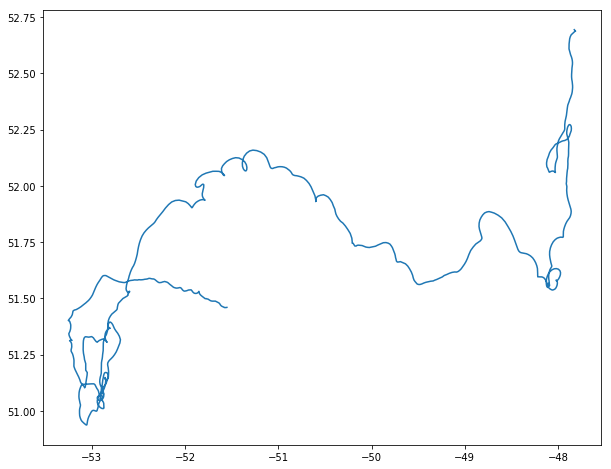

In [11]:
plt.plot(df['Longitude'], df['Latitude'])
plt.show()

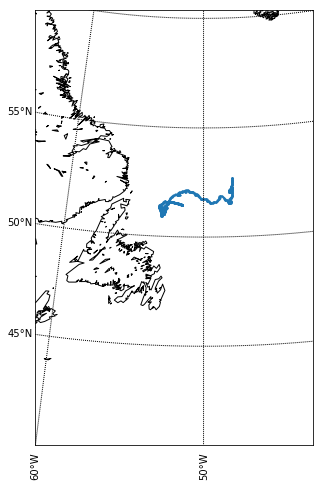

In [19]:
m = plot.get_stereographic_projection()
lons, lats = m(df['Longitude'].values, df['Latitude'].values)
m.scatter(lons, lats, s=1)
plt.show()

In [115]:
def make_beacon_stats_df(data_dir_path, data_filenames):
    
    stats_df = pd.DataFrame(columns=['start_time', 'end_time', 'lifespan', 'start_lat', 'start_lon', 
                                     'min_lat', 'min_lon', 'max_lat', 'max_lon'])
    
    for data_filename in data_filenames:
        
        df = get_df(data_dir_path, data_filename)
        stats_dict = {'start_time': None, 'end_time': None, 'lifespan': None,
                      'start_lat': None, 'start_lon': None, 
                      'min_lat': None, 'min_lon': None, 'max_lat': None, 'max_lon': None}
        
        stats_dict['start_time'] = df['DataDate_UTC'].values[0]
        stats_dict['end_time'] = df['DataDate_UTC'].values[-1]
        stats_dict['lifespan'] = stats_dict['end_time'] - stats_dict['start_time']
        stats_dict['start_lat'] = df['Latitude'].values[0]
        stats_dict['start_lon'] = df['Longitude'].values[0]
        stats_dict['end_lat'] = df['Latitude'].values[-1]
        stats_dict['end_lon'] = df['Longitude'].values[-1]
        stats_dict['min_lat'] = min(df['Latitude'].values)
        stats_dict['min_lon'] = min(df['Longitude'].values)
        stats_dict['max_lat'] = max(df['Latitude'].values)
        stats_dict['max_lon'] = max(df['Longitude'].values)
        
        
        temp_stats_df = pd.DataFrame(stats_dict, index=[df['BeaconID'].values[0]])
        stats_df = stats_df.append(temp_stats_df, sort=False)
        
        
    return stats_df
        

In [116]:
beacon_stats_df = make_beacon_stats_df(dir_path, csv_filenames)

In [117]:
beacon_stats_df.head()

,start_time,end_time,lifespan,start_lat,start_lon,min_lat,min_lon,max_lat,max_lon,end_lat,end_lon
204980,2015-04-24 15:16:06,2015-06-13 09:33:42,49 days 18:17:36,51.45991,-51.55144,50.93713,-53.25196,52.69404,-47.81201,52.69404,-47.82604
50519,2015-04-23 18:48:37,2015-06-01 02:09:54,38 days 07:21:17,49.22403,-51.25820,49.20878,-53.63311,49.82451,-51.14548,49.46962,-53.58547
90679,2015-04-24 15:21:03,2015-05-25 01:20:03,30 days 09:59:00,51.46240,-51.55285,50.06842,-54.01476,51.76071,-51.55156,50.09155,-53.06512
90778,2015-04-23 18:53:57,2015-04-23 19:57:39,0 days 01:03:42,49.22347,-51.25890,49.22226,-51.25890,49.22347,-51.24820,49.22226,-51.24820


## Plot All Tracks

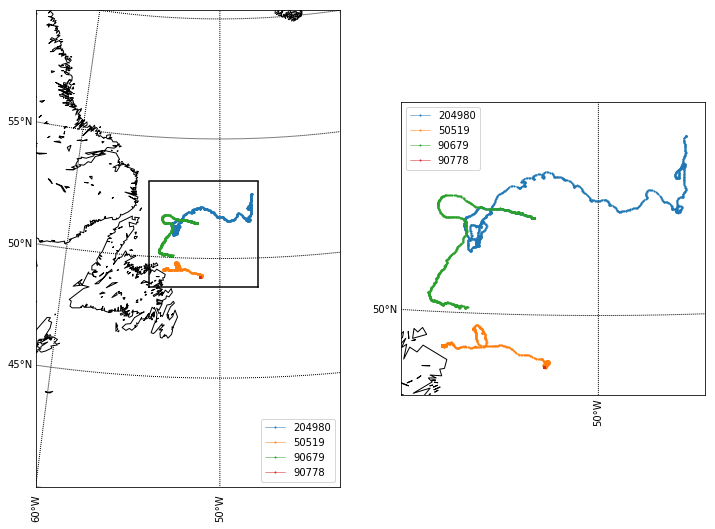

In [172]:
box_padding = 0.5  # degrees lat/lon
num_steps = 1000
min_lat = min(beacon_stats_df['min_lat']) - box_padding
min_lon = min(beacon_stats_df['min_lon']) - box_padding
max_lat = max(beacon_stats_df['max_lat']) + box_padding
max_lon = max(beacon_stats_df['max_lon']) + box_padding
bounding_lons = np.arange(min_lon, max_lon, (max_lon - min_lon) / num_steps)
bounding_lats = np.arange(min_lat, max_lat, (max_lat - min_lat) / num_steps)
assert len(bounding_lons) == len(bounding_lats)
num_bounding_lons = len(bounding_lons)
num_bounding_lats = len(bounding_lats)
min_lats = np.array([min_lat] * num_steps)
min_lons = np.array([min_lon] * num_steps)
max_lats = np.array([max_lat] * num_steps)
max_lons = np.array([max_lon] * num_steps)

plt.subplot(1, 2, 1)

m = plot.get_stereographic_projection(llcrnrlat=40, urcrnrlat=60, llcrnrlon=-60, urcrnrlon=-40)

for csv_filename in csv_filenames:
    temp_df = get_df(dir_path, csv_filename)
    temp_lons, temp_lats = m(temp_df['Longitude'].values, temp_df['Latitude'].values)
    m.plot(temp_lons, temp_lats, marker='o', linewidth=0.5, markersize=1, label=temp_df['BeaconID'].values[0])

bounding_lons, bounding_lats = m(bounding_lons, bounding_lats)
min_lons, min_lats = m(min_lons, min_lats)
max_lons, max_lats = m(max_lons, max_lats)
m.plot(bounding_lons, min_lats, color='black')
m.plot(min_lons, bounding_lats, color='black')
m.plot(bounding_lons, max_lats, color='black')
m.plot(max_lons, bounding_lats, color='black')

plt.legend()


plt.subplot(1, 2, 2)

min_lat = min(beacon_stats_df['min_lat']) - box_padding
min_lon = min(beacon_stats_df['min_lon']) - box_padding
max_lat = max(beacon_stats_df['max_lat']) + box_padding
max_lon = max(beacon_stats_df['max_lon']) + box_padding

m = plot.get_stereographic_projection(llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=min_lon, urcrnrlon=max_lon)

for csv_filename in csv_filenames:
    temp_df = get_df(dir_path, csv_filename)
    temp_lons, temp_lats = m(temp_df['Longitude'].values, temp_df['Latitude'].values)
    m.plot(temp_lons, temp_lats, marker='o', linewidth=0.5, markersize=1, label=temp_df['BeaconID'].values[0])

plt.legend()
plt.show()

# OLD - Analyzing Beacon Data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import urllib
import os

In [2]:
dir_path = 'ftp://data.munroelab.ca/pub/iceberg/beacon/'
dir_contents = urllib.request.urlopen(dir_path).read().splitlines()
filenames = [str(listing.split()[-1])[2:-1] for listing in dir_contents]
csv_filenames = [filename for filename in filenames if filename.startswith('0')
                and filename.endswith('csv')]
kml_filenames = [filename for filename in filenames if filename.startswith('0')
                and filename.endswith('kml')]
metadata_filename = filenames[-1]

URLError: <urlopen error [Errno -2] Name or service not known>

In [ ]:
beacon_metadata = pd.read_csv(dir_path + metadata_filename)

In [ ]:
beacon_metadata

In [ ]:
def get_df(data_dir_path, data_fname):
    
    df = pd.read_csv(data_dir_path + data_fname)
    df.loc[:, 'DataDate_UTC'] = pd.to_datetime(df['DataDate_UTC'])
    
    return df

In [ ]:
df = get_df(dir_path, csv_filenames[1])

In [ ]:
df.head()

In [ ]:
def get_day_idxs(dft, day_inc = 5):

    day_idxs = []
    day_js = []
    day_j = 0
    
    for i in range(len(df)):
        day = (dft[i] - dft[0]).days
        if day == day_j:
            day_idxs.append(i)
            day_js.append(day_j)
            day_j += day_inc
    
    return day_idxs, day_js

In [ ]:
def plot_drift_track(df, data_fname):
    
    fig = plt.figure()

    x, y = df['Longitude'], df['Latitude']
    
    plt.scatter(x, y, s=2)
    
    t = df['DataDate_UTC']
    day_idxs, day_js = get_day_idxs(t)
    
    for i, day_idx in enumerate(day_idxs):
    
        plt.text(x[day_idx], y[day_idx], str(day_js[i]), fontsize=16, )
    
    plt.title(f'Drift Track from {data_fname}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    return fig

# Animation

# Simulation

In [ ]:
from icedef import constants, iceberg, metocean, drift, tools

In [ ]:
def get_iceberg_velocity_from_dataframe(df, start_index, end_index):
    
    dt = (df.DataDate_UTC[end_index] - df.DataDate_UTC[start_index]).total_seconds()  
    dlat = df.Latitude[end_index] - df.Latitude[start_index]
    dlon = df.Longitude[end_index] - df.Longitude[start_index]
    
    mid_lat = (df.Latitude[end_index] + df.Latitude[start_index]) / 2
    
    dy = tools.dlat_to_dy(dlat)
    dx = tools.dlon_to_dx(dlon, mid_lat)
    
    vx = dx/dt
    vy = dy/dt
    
    v = (vx, vy)
    
    return v

In [ ]:
csv_filenames

In [ ]:
def drift_wrapper(berg_inits, meto, time_info, **kwargs):
    
    start_time, start_latitude, start_longitude, start_velocity = berg_inits
    
    berg = iceberg.quickstart(start_time, (start_latitude, start_longitude), 
                              velocity=start_velocity)
            
    time_step, end_time = time_info
    dt = time_step.item().total_seconds()

    berg_constants = {
    'form_drag_coefficient_in_air': kwargs.pop('Ca', berg.FORM_DRAG_COEFFICIENT_IN_AIR),
    'form_drag_coefficient_in_water': kwargs.pop('Cw', berg.FORM_DRAG_COEFFICIENT_IN_WATER),
    'skin_drag_coefficient_in_air': berg.SKIN_DRAG_COEFFICIENT_IN_AIR,
    'skin_drag_coefficient_in_water': berg.SKIN_DRAG_COEFFICIENT_IN_WATER,
    'sail_area': berg.geometry.sail_area,
    'keel_area': berg.geometry.keel_area,
    'top_area': berg.geometry.waterline_length**2,
    'bottom_area': 0,
    'mass': berg.geometry.mass,
    'latitude': berg.latitude
    }
        
    point = (berg.time, berg.latitude, berg.longitude)
    
    current_velocity = (meto.interpolate(point, meto.ocean.eastward_velocities),
                        meto.interpolate(point, meto.ocean.northward_current_velocities))

    wind_velocity = (meto.interpolate(point, meto.atmosphere.eastward_wind_velocities),
                     meto.interpolate(point, meto.atmosphere.northward_wind_velocities))

    while berg.time < end_time:
        
        berg.update_history()

        ax, ay = drift.newtonian_drift((berg.eastward_velocity, berg.northward_velocity), 
                                 current_velocity, wind_velocity, 
                                 berg_constants)

        berg.time += time_step
        berg.eastward_velocity += ax * dt
        berg.northward_velocity += ay * dt
        berg.latitude += tools.dy_to_dlat(berg.northward_velocity * dt)
        berg.longitude += tools.dx_to_dlon(berg.eastward_velocity * dt, berg.latitude)

        point = (berg.time, berg.latitude, berg.longitude)

        current_velocity = (meto.interpolate(point, meto.ocean.eastward_velocities),
                            meto.interpolate(point, meto.ocean.northward_current_velocities))

        wind_velocity = (meto.interpolate(point, meto.atmosphere.eastward_wind_velocities),
                         meto.interpolate(point, meto.atmosphere.northward_wind_velocities))

        berg_constants['latitude'] = berg.latitude
            
    return berg

In [ ]:
df = get_df(dir_path, csv_filenames[2])

start_index = 1100
end_index = 1120

start_time = np.datetime64(df.DataDate_UTC[start_index])
start_latitude = df.Latitude[start_index]
start_longitude = df.Longitude[start_index]
start_velocity = get_iceberg_velocity_from_dataframe(df, start_index, start_index + 10)

end_time = np.datetime64(df.DataDate_UTC[end_index])

ref_berg = iceberg.quickstart(start_time, (start_latitude, start_longitude))

for i in range(end_index - start_index + 2):

    ref_berg.time = np.datetime64(df.DataDate_UTC[start_index + i])
    ref_berg.latitude = df.Latitude[start_index + i]
    ref_berg.longitude = df.Longitude[start_index + i]
    ref_berg.update_history()

time_step = np.timedelta64(360, 's')
#dt = time_step.item().total_seconds()
#nt = int((end_time - start_time) / time_step)

time_info = (time_step, end_time)

berg = iceberg.quickstart(start_time, (start_latitude, start_longitude), velocity=start_velocity)

meto = metocean.Metocean((start_time, end_time))

In [ ]:
berg2 = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                      meto, time_info, Ca=3, Cw=0.1)
berg3 = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                      meto, time_info, Ca=0.1, Cw=5)

In [ ]:
plt.scatter(berg2.history['longitude'], berg2.history['latitude'], s=2, label='iceberg2')
plt.scatter(berg3.history['longitude'], berg3.history['latitude'], s=2, label='iceberg3')

plt.scatter(ref_berg.history['longitude'], ref_berg.history['latitude'], s=4, label='beacon')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Beacon Drift Track')
plt.show()

# Optimization

In [ ]:
from scipy.optimize import minimize

In [ ]:
def optimization_wrapper(form_drag_coefficients, ref_berg, berg_inits, meto, time_info):
    
    Ca, Cw = form_drag_coefficients
    
    berg = drift_wrapper(berg_inits, meto, time_info, Ca=Ca, Cw=Cw)
    
    try:
        mse = tools.compute_mse((berg.longitude, berg.latitude, berg.time),
                           (ref_berg.history['longitude'], ref_berg.history['latitude'], ref_berg.history['time']),
                           ref_berg.history['time'][0] - np.timedelta64(1,'D'))
    except:
        print(berg2.time)
        raise
    
    return mse
    

In [ ]:
callback_mses = []
callback_Cas = []
callback_Cws = []

def callback(x):
    
    result = optimization_wrapper(x, ref_berg, (start_time, start_latitude, start_longitude, start_velocity), 
                                     meto, time_info)
    callback_mses.append(result)
    callback_Cas.append(x[0])
    callback_Cws.append(x[1])

In [ ]:
# WARNING: make sure to re-init berg before running minimization

berg = iceberg.quickstart(start_time, (start_latitude, start_longitude), velocity=start_velocity)

optimization_result = minimize(optimization_wrapper, x0=(1, 1), bounds=((0.5, 15), (0.5, 15)), 
                               args=(ref_berg, (start_time, start_latitude, start_longitude, start_velocity), 
                                     meto, time_info), callback=callback)
optimization_result

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(np.array(callback_Cas), np.array(callback_Cws), np.array(callback_mses))

ax.set_xlabel('Ca')
ax.set_ylabel('Cw')
ax.set_zlabel('MSE')

plt.show()

In [ ]:
# WARNING: make sure to re-init berg before running minimization

berg = iceberg.quickstart(start_time, (start_latitude, start_longitude), velocity=start_velocity)

optimization_result = minimize(optimization_wrapper, x0=(1, 1), bounds=((0, 15), (0, 15)), 
                               args=(ref_berg, (start_time, start_latitude, start_longitude, start_velocity), 
                                     meto, time_info), callback=callback)
optimization_result

In [ ]:
berg = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                      meto, time_info, Ca=optimization_result.x[0], Cw=optimization_result.x[1])

plt.scatter(berg.history['longitude'], berg.history['latitude'], s=2, label='model')
#plt.scatter(berg3.history['longitude'], berg3.history['latitude'], s=2, label='iceberg3')

plt.scatter(ref_berg.history['longitude'], ref_berg.history['latitude'], s=5, label='beacon')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Beacon Drift Track')
plt.show()